In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import zipfile
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

ZIP_PATH = '/content/drive/MyDrive/AI_Projects/Chest X-Ray Images.zip'
EXTRACT_PATH = '/content/dataset'

if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

TRAIN_DIR = '/content/dataset/chest_xray/train'
TEST_DIR = '/content/dataset/chest_xray/test'

medical_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=medical_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=medical_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def build_medical_model(num_classes=2):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    for param in model.features.parameters():
        param.requires_grad = False

    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Linear(512, num_classes)
    )
    return model

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_medical_model().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 183MB/s]


In [ ]:
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {running_loss/len(train_loader.dataset):.4f}")

Epoch 1/10 | Loss: 0.2540
Epoch 2/10 | Loss: 0.1605
Epoch 3/10 | Loss: 0.1434
Epoch 4/10 | Loss: 0.1366
Epoch 5/10 | Loss: 0.1160
Epoch 6/10 | Loss: 0.1091
Epoch 7/10 | Loss: 0.0925
Epoch 8/10 | Loss: 0.0988
Epoch 9/10 | Loss: 0.0980
Epoch 10/10 | Loss: 0.1111


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

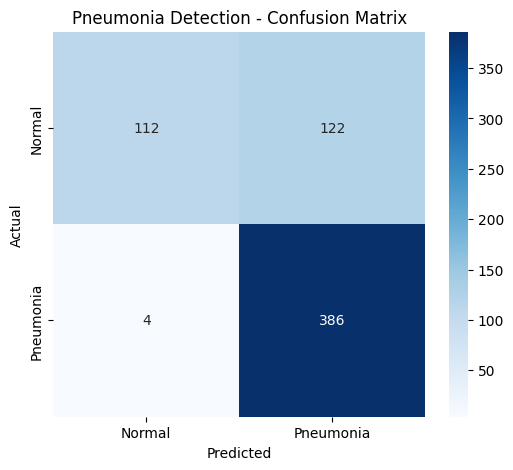

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Pneumonia Detection - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.97      0.48      0.64       234
   Pneumonia       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.73      0.75       624
weighted avg       0.84      0.80      0.78       624



In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI_Projects/pneumonia_model.pth')